In [2]:
# --- Phase 1: fetch, align, and summarize PocketBase data ---

from pb_client import fetch_records
import pandas as pd

# 1. Pull your PocketBase data
glucose = pd.DataFrame(fetch_records("glucose"))
steps   = pd.DataFrame(fetch_records("steps"))

# 2. Convert timestamps to datetime
glucose["timestamp"] = pd.to_datetime(glucose["timestamp"])
steps["timestamp"]   = pd.to_datetime(steps["timestamp"])

# 3. Resample to 5-minute bins
#    (average glucose, sum of steps)
g = (
    glucose.set_index("timestamp")[["value_mgdl"]]   # <-- your actual field name
    .resample("5min")
    .mean()
    .rename(columns={"value_mgdl": "glucose"})
)
s = (
    steps.set_index("timestamp")[["steps"]]
    .resample("5min")
    .sum()
)

# 4. Merge and aggregate per day
daily = (
    g.join(s, how="outer")
    .resample("1D")
    .agg({
        "glucose": ["mean", "std"],
        "steps": ["sum"]
    })
)

# 5. Flatten column names and tidy up
daily.columns = ["glucose_mean", "glucose_std", "steps_sum"]
daily = daily.reset_index().rename(columns={"timestamp": "day"})

print("✅ Daily summary ready — showing last 10 days:\n")
print(daily.tail(10))


📡 Fetching glucose page 1...
📡 Fetching glucose page 2...
📡 Fetching glucose page 3...
📡 Fetching glucose page 4...
📡 Fetching glucose page 5...
📡 Fetching glucose page 6...
📡 Fetching glucose page 7...
📡 Fetching glucose page 8...
📡 Fetching glucose page 9...
📡 Fetching glucose page 10...
📡 Fetching glucose page 11...
📡 Fetching glucose page 12...
📡 Fetching glucose page 13...
📡 Fetching glucose page 14...
📡 Fetching glucose page 15...
📡 Fetching glucose page 16...
📡 Fetching glucose page 17...
📡 Fetching glucose page 18...
📡 Fetching glucose page 19...
📡 Fetching glucose page 20...
📡 Fetching glucose page 21...
📡 Fetching glucose page 22...
📡 Fetching glucose page 23...
📡 Fetching glucose page 24...
📡 Fetching glucose page 25...
📡 Fetching glucose page 26...
📡 Fetching glucose page 27...
📡 Fetching glucose page 28...
📡 Fetching glucose page 29...
📡 Fetching glucose page 30...
📡 Fetching glucose page 31...
📡 Fetching glucose page 32...
📡 Fetching glucose page 33...
📡 Fetching glucose 

/var/folders/kk/1h6z_xq147lcx05kwdb7jgrc0000gn/T/ipykernel_56727/12654746.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(s, dx=dt_minutes)


✅ Phase 2 features — last 10 days:

                         day  glucose_mean  glucose_std  glucose_cv  \
20 2025-09-28 00:00:00+00:00    106.216783    24.553883   23.116764   
21 2025-09-29 00:00:00+00:00    101.111111    16.061776   15.885273   
22 2025-09-30 00:00:00+00:00    104.989510    19.957935   19.009457   
23 2025-10-01 00:00:00+00:00    100.664336     7.653408    7.602899   
24 2025-10-02 00:00:00+00:00    104.527778    17.057167   16.318311   
25 2025-10-03 00:00:00+00:00    106.781250    29.108425   27.259866   
26 2025-10-04 00:00:00+00:00    114.866197    27.604278   24.031681   
27 2025-10-05 00:00:00+00:00    117.625000    21.563899   18.332752   
28 2025-10-06 00:00:00+00:00    106.337979    10.597898    9.966240   
29 2025-10-07 00:00:00+00:00    116.817610    13.470834   11.531509   

    glucose_tir_70_140  glucose_auc_min  steps_sum  
20            0.930070         151352.5      19326  
21            0.954861         144880.0      12305  
22            0.923077 

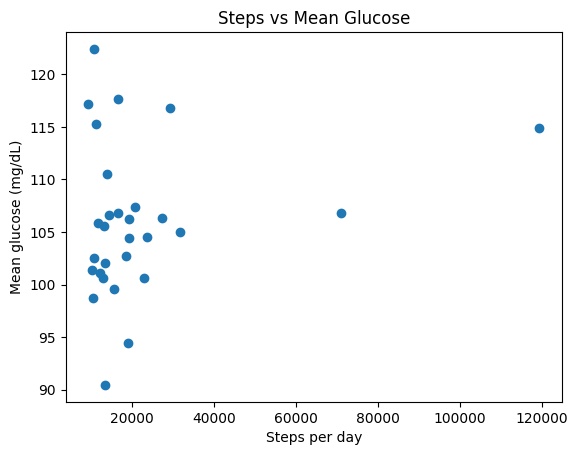


📊 Correlations with glucose_mean:

glucose_mean          1.000000
glucose_std           0.563208
glucose_auc_min       0.529112
glucose_cv            0.415766
steps_sum             0.217106
glucose_tir_70_140   -0.773480
Name: glucose_mean, dtype: float64


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Feature helpers on 5-min series (resampled already as 'g' with column 'glucose') ---

def time_in_range(series, low=70, high=140):
    """Proportion of time points within [low, high]."""
    s = series.dropna()
    if s.empty: return np.nan
    return (s.between(low, high).mean())  # fraction 0..1

def auc_trapezoid(series, dt_minutes=5):
    """
    Approximate daily AUC via trapezoidal rule on 5-min grid.
    Returns mg/dL * min (area under curve in minute-units).
    """
    s = series.dropna().to_numpy()
    if s.size < 2: return np.nan
    return np.trapz(s, dx=dt_minutes)

def coeff_variation(series):
    s = series.dropna()
    if s.empty or s.mean() == 0: return np.nan
    return 100.0 * (s.std() / s.mean())

# --- Build a per-day feature table from your 5-min dataframes g (glucose) and s (steps) ---

# Ensure we’re on the right index and names
g5 = g.copy()            # index = timestamp, column = 'glucose' (we set this earlier)
s5 = s.copy()            # index = timestamp, column = 'steps'

# Aggregate to per-day features
feat = pd.DataFrame(index=g5.resample("1D").mean().index)

# Glucose stats
feat["glucose_mean"] = g5["glucose"].resample("1D").mean()
feat["glucose_std"]  = g5["glucose"].resample("1D").std()
feat["glucose_cv"]   = g5["glucose"].resample("1D").apply(coeff_variation)   # %
feat["glucose_tir_70_140"] = g5["glucose"].resample("1D").apply(time_in_range)  # 0..1
feat["glucose_auc_min"]    = g5["glucose"].resample("1D").apply(auc_trapezoid)  # mg/dL * min

# Steps stats
feat["steps_sum"] = s5["steps"].resample("1D").sum()

# Clean up index/columns
feat = feat.reset_index().rename(columns={"index":"day", "timestamp":"day"})

# Preview
print("✅ Phase 2 features — last 10 days:\n")
print(feat.tail(10))

# --- Quick sanity viz: steps vs. mean glucose ---
plt.figure()
plt.scatter(feat["steps_sum"], feat["glucose_mean"])
plt.xlabel("Steps per day")
plt.ylabel("Mean glucose (mg/dL)")
plt.title("Steps vs Mean Glucose")
plt.show()

# --- Optional: correlations table (quick feel for relationships) ---
print("\n📊 Correlations with glucose_mean:\n")
print(feat[["glucose_mean","glucose_std","glucose_cv","glucose_tir_70_140","glucose_auc_min","steps_sum"]]
      .corr()["glucose_mean"]
      .sort_values(ascending=False))
